In [2]:
import ramanspy as rp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import cv2
from joblib import Parallel, delayed
from sklearn.cluster import OPTICS

# Loading Data

In [3]:
# Take data and wl from their locations in the PC. Adjust it with respect to their locations.
data = np.loadtxt(r"/root/raman raw data/data_Kont_D16_ZT6_16H.txt")
wl = np.loadtxt(r"/root/raman raw data/wl.txt")

# The following changes in data cause the 2d data to be converted into 3d data.
data = np.transpose(data)
data = data.reshape(1044,601,277) # Adjust it with respect to the  data. 1044: length of vectors in every pixel, 601: x-length, 277: y-length
data = data.transpose(0,2,1)
print(data.shape)

(1044, 277, 601)


9.196178674697876

# Preprocess

In [4]:
# Gaussian to detect the maximum
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / stddev) ** 2 / 2)

x_data = wl[:10]

row = data.shape[1]
column = data.shape[2]

new_spectral_axis = np.arange(800,1800)
new_spectral_data_3d = np.random.rand(1000,row,column)

In [5]:
# Necessary preprocessing

def process_pixel(i, j, data, x_data, new_spectral_axis):
    y_data = data[:, i, j][:10]
    
    initial_guess = [5300, 785, 1]  # Initial guess for amplitude, mean, and standard deviation
    fit_params, _ = curve_fit(gaussian, x_data, y_data, p0=initial_guess)
    
    peak_x = fit_params[1]
                
    spectral_axis = rp.utils.wavelength_to_wavenumber(wl, laser_excitation=peak_x)
    raman_spectrum = rp.preprocessing.normalise.Vector(pixelwise=True).apply(
        rp.preprocessing.denoise.Kernel(kernel_type='flat', kernel_size=3).apply(
        rp.preprocessing.baseline.IASLS(lam=1000000.0, p=0.01, lam_1=0.0001, max_iter=50, tol=0.001,
                                        weights=None, diff_order=3).apply(
        rp.preprocessing.despike.WhitakerHayes(kernel_size=3, threshold=4).apply(
        rp.preprocessing.misc.Cropper(region=[800, 1800]).apply(
        rp.Spectrum(data[:, i, j], spectral_axis)
    )))))
    
    spectral_data = np.interp(new_spectral_axis, raman_spectrum.spectral_axis, raman_spectrum.spectral_data)
    
    return i, j, spectral_data

# Parallel processing
results = Parallel(n_jobs=-1)(delayed(process_pixel)(i, j, data, x_data,new_spectral_axis
                                                   ) for i in range(row) for j in range(column))

# Populate the new_spectral_data_3d array with results
for i, j, spectral_data in results:
    new_spectral_data_3d[:, i, j] = spectral_data

(1000, 277, 601)


38.790995597839355

In [6]:
new_spectral_data_3d = new_spectral_data_3d.transpose(1,2,0)

In [7]:
new_spectral_data_3d.shape

(277, 601, 1000)

# PCA

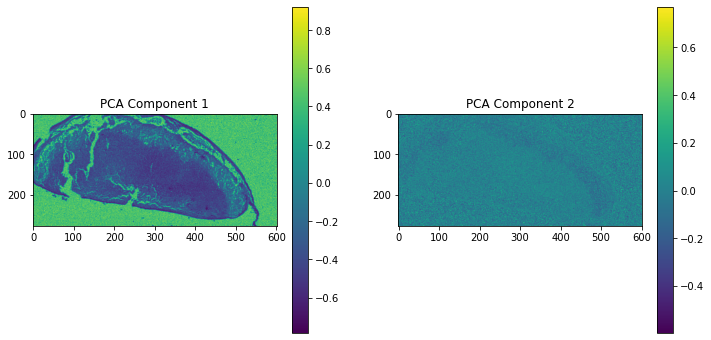

In [8]:
n_samples, n_features, n_bands = new_spectral_data_3d.shape

flattened_data = new_spectral_data_3d.reshape(-1, n_bands)

# Apply PCA to reduce dimensions for clustering (optional, but often helpful)
pca = PCA(n_components=100)
pca_result = pca.fit_transform(flattened_data)

pca_result_reshaped = pca_result.reshape(n_samples, n_features, 100)

# Visualize the PCA components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(pca_result_reshaped[:, :, 0], cmap='viridis')
plt.colorbar()
plt.title("PCA Component 1")

plt.subplot(1, 2, 2)
plt.imshow(pca_result_reshaped[:, :, 1], cmap='viridis')
plt.colorbar()
plt.title("PCA Component 2")

plt.show()

# Silhouette Score

In [9]:
min_samples = int((n_samples * n_features) / 5)  # Number of samples in a neighborhood for a point to be considered a core point

In [10]:
eps_values = np.arange(0.2, 0.75, 0.1)

def evaluate_optics(eps, pca_result, min_samples):
    optics = OPTICS(min_samples=min_samples, max_eps=eps, n_jobs=-1)
    clusters = optics.fit(pca_result)
    
    # Ignore -1 labels (noise) when computing silhouette score
    if len(set(clusters.labels_)) > 1:
        score = silhouette_score(pca_result, clusters.labels_, sample_size=int((n_samples*n_features)/10))
    else:
        score = -1
    return score

In [11]:
silhouette_scores = Parallel(n_jobs=-1)(delayed(evaluate_optics)(eps, pca_result, min_samples) for eps in eps_values)

12368.424762487411

In [12]:
best_eps = eps_values[np.argmax(silhouette_scores)]
eps_values_new = np.arange(best_eps - 0.05, best_eps + 0.07, 0.02)

In [13]:
silhouette_scores_new = Parallel(n_jobs=-1)(delayed(evaluate_optics)(eps, pca_result, min_samples) for eps in eps_values_new)

19850.697283506393

# OPTICS

In [14]:
t0=time.time()

best_eps_new = eps_values_new[np.argmax(silhouette_scores_new)]
optics_new = OPTICS(min_samples=min_samples, max_eps=best_eps_new, n_jobs=-1)
clusters_new = optics_new.fit(pca_result)

t1=time.time()
t1-t0

2695.72899723053

In [17]:
cluster_labels_reshaped = clusters_new.labels_.reshape(n_samples,n_features)

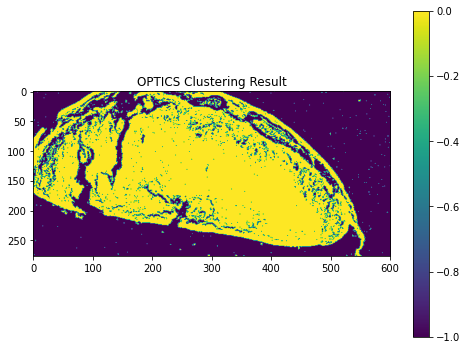

In [18]:
plt.figure(figsize=(8, 6))
plt.imshow(cluster_labels_reshaped, cmap='viridis')
plt.colorbar()
plt.title("OPTICS Clustering Result")
plt.show()

 # If the clustering result looks incorrect, change the min_samples value!

# Connected Components

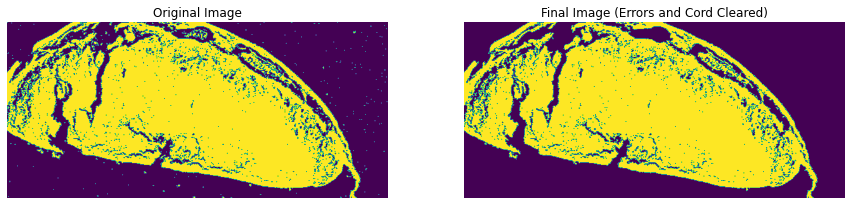

In [21]:
image = cluster_labels_reshaped

num_labels, labels_im = cv2.connectedComponents((image == 0).astype(np.uint8))

# Determine the size of each component
component_sizes = np.bincount(labels_im.flatten())

largest_label = np.argmax(component_sizes[1:]) + 1

# Create the final image: keep only the largest component, set others to -1
final_image = image.copy()
final_image[(labels_im != largest_label) & (labels_im != 0)] = -1

# Display the results
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(image, cmap='viridis')
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(final_image, cmap='viridis')
axs[1].set_title('Final Image (Errors and Cord Cleared)')
axs[1].axis('off')

plt.show()

# Removing the vectors on metal pixels.

In [22]:
updated_spectral_data_3d = new_spectral_data_3d.copy()

In [23]:
for i in np.arange(np.count_nonzero(final_image)):
    updated_spectral_data_3d[np.where(final_image==-1)[0][i]][np.where(final_image==-1)[1][i]] = 0

In [24]:
y=np.zeros(1000)
for i in np.arange(row):
    for j in np.arange(column):
        for k in np.arange(1000):
            y[k] += updated_spectral_data_3d[i,j,k]
#new_spectral_axis[np.where(y==y.max())[0][0]]

<Axes: title={'center': 'Raman spectra'}, xlabel='Raman shift (cm$^{{{-1}}}$)', ylabel='Intensity (a.u.)'>

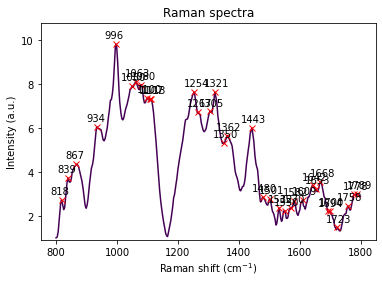

In [25]:
total_spec=rp.Spectrum(y/1000,new_spectral_axis)
rp.plot.peaks(total_spec)

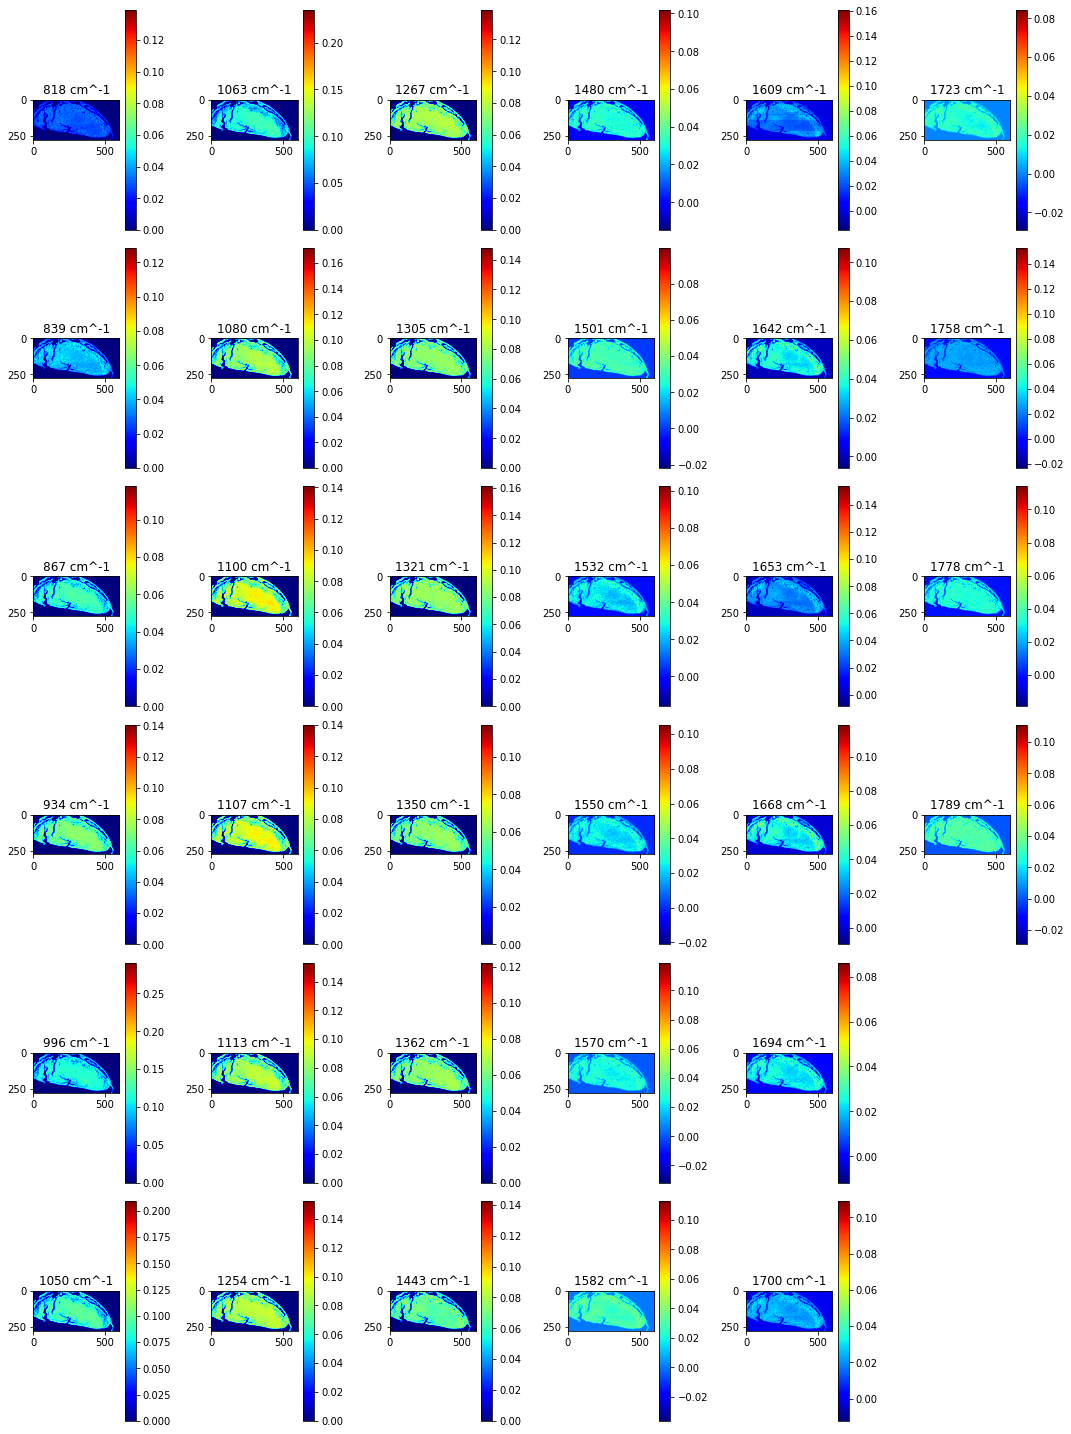

In [26]:
nmb_col = (total_spec.peaks()[0].shape[0])//6
fig, axes = plt.subplots(6, nmb_col+1 , figsize=(15, 20))
our_range = ((total_spec.peaks()[0].shape[0])//6)*6
remainder = total_spec.peaks()[0].shape[0]%6

for i in np.arange(total_spec.peaks()[0].shape[0]):
    if i < our_range: 
        row = (i % 6) 
        col = (i // 6)
    else:
        row = (i - our_range)
        col = nmb_col
    
    im = axes[row, col].imshow(updated_spectral_data_3d[:,:,total_spec.peaks()[0][i]], cmap='jet')
    axes[row, col].title.set_text(str(new_spectral_axis[total_spec.peaks()[0][i]]) + ' cm^-1')
    fig.colorbar(im, ax=axes[row, col])

for r in range(6):
    for c in range(nmb_col+1):
        if (r, c) not in [(i % 6, i // 6) for i in range(our_range)] and (r, c) not in [(i, nmb_col) for i in range(remainder)]:
            fig.delaxes(axes[r, c])

fig.tight_layout()
plt.show()

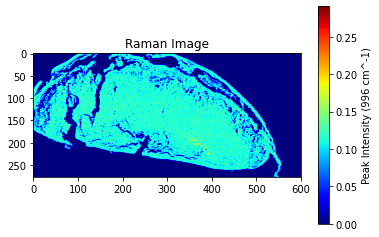

In [27]:
plt.imshow(updated_spectral_data_3d[:,:,np.where(y==y.max())[0][0]],cmap='jet')
plt.colorbar(label = "Peak Intensity (" +str(new_spectral_axis[np.where(y==y.max())[0][0]]) + " cm^-1)")
plt.title("Raman Image")
plt.show()

# Saving the resulting data as a 2d txt file.

In [28]:
updated_spectral_data_2d = updated_spectral_data_3d.reshape(n_samples*n_features,n_bands)

In [29]:
# Adjust the location with respect to your PC.
np.savetxt(r"/root/raman raw data/updated_Kont_D16_ZT6_16H.txt", updated_spectral_data_2d)